In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import matplotlib.cm as cm
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import matplotlib.colors as colors

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

In [2]:
# configure the place, network type, trip times, and travel speed
place = "Tartu, Estonia"
network_type = "drive"
trip_times = [1, 2, 3, 4, 5]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

In [12]:
# download the street network
G = ox.graph_from_place(place, network_type=network_type)

In [4]:
#Get bus station dat afrom OSM
G_stops = ox.geometries_from_place("Tartu, Estonia",tags={"highway":"bus_stop"})
x = G_stops.geometry.x
y = G_stops.geometry.y


In [5]:
# project bus stops to the nearest intersection node
stop_nodes = ox.distance.nearest_nodes(G, x, y)
G = ox.project_graph(G)

/home/simo/miniconda3/envs/map/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute


/home/simo/miniconda3/envs/map/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)
iso_colors

['#0d0887', '#7e03a8', '#cc4778', '#f89540', '#f0f921']

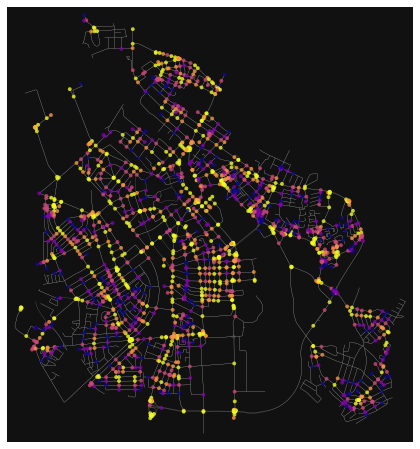

In [8]:
# color the nodes according to isochrone then plot the street network


node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    for stop_node in stop_nodes:
        subgraph = nx.ego_graph(G, stop_node, radius=trip_time, distance="time")
        for node in subgraph.nodes():
            node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
    show=False,
    close=False,
)
#ax.scatter(x,y,color="red")



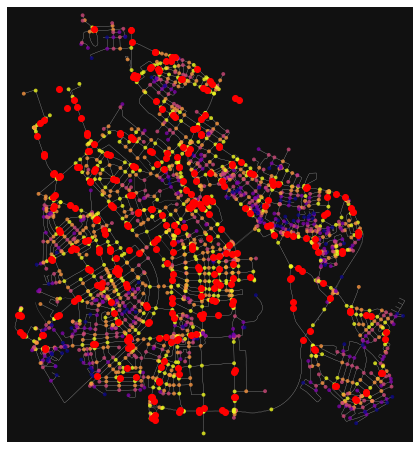

In [13]:
#same as abowe, but bus stations added to the map

node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    for stop_node in stop_nodes:
        subgraph = nx.ego_graph(G, stop_node, radius=trip_time, distance="time")
        for node in subgraph.nodes():
            node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
    show=False,
    close=False,
)
ax.scatter(x,y,color="red")



In [15]:
df = pd.read_excel("liiklusonnetused_2011_2020.xlsx",index_col=0)

In [16]:
df["Lat"] = pd.to_numeric(df.Lat.str.replace(",","."))
df["Lon"] = pd.to_numeric(df.Lon.str.replace(",","."))

In [17]:
#bbox if needed
#left=26.64 bottom=58.33 right=26.81 top=58.42

sub_df = (df.loc[(df['Lat'] < 58.42) & (df['Lat'] > 58.33) & (df['Lon'] < 26.81) & (df['Lon'] > 26.64)])

/home/simo/miniconda3/envs/map/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


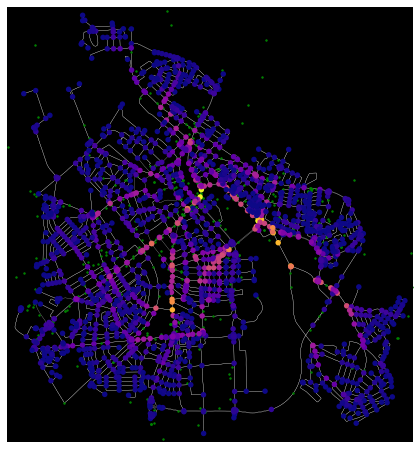

In [21]:
lat = sub_df.Lat
lon = sub_df.Lon

# add the betweenness centraliy values as new node attributes, then plot
bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
    show=False,
    close=False,
)
ax.scatter(lon,lat,color="green", s=2.0)


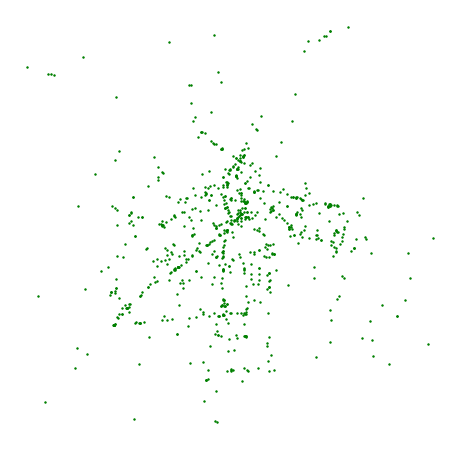

In [35]:
plt.rcParams["figure.figsize"] = (8,8)
plt.axis('off')
plt.scatter(lon,lat,color="green", s=2.0)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]